# 项目目标

# 调包区

In [1]:
from tqdm.notebook import tqdm
import random
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import gc
import os

# 警告忽略
import warnings
warnings.filterwarnings("ignore")

# matplotlib字体设置
plt.rcParams["font.family"] = "Songti SC"
plt.rcParams["axes.unicode_minus"] = False

# matplotlib警告忽略
pd.plotting.register_matplotlib_converters()


# 观看Dataframe长度
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
# 浮点数位长度
pd.set_option('display.precision',5)

# 显示多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # ['all', 'last', 'last_expr', 'none', 'last_expr_or_assign']

In [2]:
# 保存模块
import pickle
def pickle_save(path,stuff):
    if type(stuff)==type(collections.defaultdict(lambda : 0)):
        stuff = dict(stuff)
    with open(path,"wb") as file:
        pickle.dump(stuff,file)
    
def pickle_load(path):
    with open(path,"rb")as file:
        stuff = pickle.load(file)
        
    if type(stuff)==type(collections.defaultdict(lambda : 0)):
        stuff = collections.defaultdict(lambda : 0,stuff) # 定义模拟器的初始状态
        
    return stuff


In [3]:
from datetime import datetime
import jqdatasdk as jq

# 登陆
jq.auth('18689717301', 'Zz.7895123')
#jq.auth('13282159964', '159964')


# 查询使用次数
count=jq.get_query_count()
print("当日可调用数据总条数为：",count['total'])
print("当日剩余可调用条数为：",count['spare'])


提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
auth success 
当日可调用数据总条数为： 1000000
当日剩余可调用条数为： 628670


# 筛选策略代码

## 行业查询

In [4]:
def select_industry():
    # 显示所有行业
    # 计算机、通信和其他电子设备制造业 C39
    temp = jq.get_industries() # 得到行业
    print(temp['name'].to_string())

    # 选择行业
    industry = input('输入你选择的行业:')
    industry = temp[temp['name']==industry].index[0]
    
    return industry



## 股票选择市盈率、市值策略

In [5]:
def select_code(industry,start_date):
    ############################################################
    # 策略筛选股票代码
    benchmark_date = start_date
    pool = jq.get_industry_stocks(industry, date=benchmark_date)


    ############################################################
    # 得到行业股票的所有业绩情况

    # 制定搜索条件
    q = jq.query(jq.valuation.code, jq.valuation.pe_ratio, jq.valuation.market_cap).\
        filter(jq.valuation.pe_ratio > 0, jq.valuation.code.in_(pool)). \
        order_by(jq.valuation.pe_ratio.asc())

    # 其中：
    # query为需要搜索的方向
    # filter为搜索方向内的搜索范围
    # order_by 排序方式，此处是以pe市盈率为依据进行升序排序 asc升序，desc 降序
    # 此处只搜索与000001有关系的信息

    # 获取价格之外的基本信息 （其中 q 的搜索条件）

    df = jq.get_fundamentals(q, start_date)


    ############################################################
    # 进行规则筛选
    pe_mean  = df['pe_ratio'].mean()
    mc_mean = df['market_cap'].mean()

    df = df[(df['pe_ratio']<pe_mean)&(df['market_cap']>mc_mean)]


#     # 得到指定股票的价格信息
#     ############################################################
#     # 得到行业的所有股票信息（2020年所有的信息）
#     pool = df['code'].tolist() 
#     df = jq.get_price(pool, start_date="2020-01-01", end_date="2021-01-01")
    return df




# 进行资金分配

## 平均分配策略

In [6]:
################################################################
# 资金分配策略（平均分配）
def price_strategy_avg(cash,code_list):
    price_avg = cash/len(code_list)

    money_df = {code:price_avg for code in code_list}
    return money_df



# 进行股票买卖信号的判断

## MACD策略

In [7]:
def get_signal_macd(code,start_date,end_date,ma1,ma2,dea,info=False):
    ######################################################
    # 从股票代码得到该股票的历史价格数据
    df = jq.get_price(code, start_date, end_date)

    
    ######################################################
    # 计算各类指标

    # rolling函数的用法相当于滑动窗口，将前N个数据当作一个series，然后做统计操作
    # 参数：window是滑动的窗口数，min_periods是最小必须满足的窗口数（如果为1，即使窗口数为4，实际数量为2，也不会输出nan，而是取2的统计值）


    # 计算指标 (以下仅仅是常用指标，并不代表最终一定能用到)
    df['ma1'] = df['close'].rolling(window=ma1,min_periods=1).mean() # MA1是短期的平均平滑指标
                                                                     # 通过均值代表整体情况，减少波动
    df['ma2'] = df['close'].rolling(window=ma2,min_periods=1).mean() # MA2是长期期的平均平滑指标
                                                                     # 通过均值代表整体情况，减少波动
    df['diff'] = df['ma1'] - df['ma2'] # 其实就是MACD，MACD就是所有diff的情况
                                       # 这里的平滑相当于差分的概念吗？用现在与未来相减，只留下趋势项
                                       # 假设该时间序列数据仅有趋势规律的话，差分后的数值就是趋于平稳的

    df['dea'] = df['diff'].rolling(window=dea,min_periods=1).mean() # 通过均值取一段时间的平均情况，平滑整体数据


    ######################################################
    # 计算买卖拐点
    df['positions'] = (df['diff']>=df['dea']).astype(int).values
    df['signals'] = df['positions'].diff().fillna(1)



    ######################################################
    # 绘制买卖拐点
    if info==True:
        # 定义DF
        columns = ['close','signals','diff','dea']
        tem_df = df[columns]
        
        # 绘制快慢线
        tem_df[['diff','dea']].plot()

        # 只显示时刻点，不显示折线图 => 设置 linewidth=0
        tem_df['close'].plot(figsize=(15,10))

        #添加垂直直线
        x_list=tem_df['close'][(tem_df['signals']==1)|(tem_df['signals']==-1)].index
        for x in x_list:
            plt.axvline(x=x,ls="--",c="b")

        # 绘制买卖拐点
        tem_df['close'][tem_df['signals']==1].plot(label='Buy', linewidth=0, marker='^', c='r') 
        tem_df['close'][tem_df['signals']==-1].plot(label='Sell', linewidth=0, marker='^', c='g')
        
        plt.show()
        
    # 输出为两个，一个是详细信息，一个是纯signal.这样设置是为了方便之后进行多模型的投票而有的
    return df,df['signals']



# 股票买卖模拟器

## 买入股票

In [8]:
# 买入股票
def buy_stock(port,code_name,code_price,buy_date,info=True):
    # 定位股票
    df = jq.get_price(code_name, start_date=buy_date, end_date=buy_date)

    # 得到价格
    price = df['open']

    if price.empty:
        print('股票不存在or不再交易日内')
        return port

    # 转化为购买数量
    buy_count = code_price/price
    buy_count = int(buy_count)

    
    if port['cash']<code_price:
        print('不够钱买股票，本次交易取消')
        return port
    
    # 更新数据
    port[code_name]+=buy_count # 更新购买的数量
    
    port['cash']-=code_price # 更新现金,减去原定买入的金额code_price
    
    if info==True:
        cash = port['cash']
        print(f'日期:{buy_date},买入:{code_name},数量:{buy_count},金额:{code_price},剩余现金:{cash}')
    return port
    


## 卖出股票

In [9]:
# 卖出股票
def sell_stock(port,code_name,code_price,sell_date,info=True):
    # 定位股票
    df = jq.get_price(code_name, start_date=sell_date, end_date=sell_date)

    # 得到价格
    price = df['open']

    if price.empty:
        print('股票不存在or不再交易日内')
        return port
    
    price = price.iloc[0]
    
    # 得到卖出数量
    sell_count = code_price/price
    
    # 检查持仓数量(如果持仓数少于卖出数，则变为全部卖出)
    if port[code_name]<sell_count:
        print('卖出全部持有股票')
        sell_count = port[code_name]

    # 计算卖出的金额
    price  = price * sell_count

    # 更新数据
    port[code_name]-=sell_count # 更新购买的数量
    port['cash']+=price # 更新现金
    
    if info==True:
        cash = port['cash']
        print(f'日期:{sell_date},卖出:{code_name},数量:{sell_count},金额:{price},剩余现金:{cash}')
    
    return port


## 检查剩余资产

In [10]:
# 检查剩余资产
def check_stock(port,today_data):
    value = 0
    for code,count in port.items():
        if code == 'date':
            continue
        
        if code == 'cash':
            value+=count

        else:
            # 定位股票
            df = jq.get_price(code, start_date=today_data, end_date=today_data)

            # 得到价格
            price = df['open']

            if price.empty:
                print('股票不存在or不再交易日内,以下价值仅包含现金')
                #return port
            else:
                value_ = price[0] * count

                value+=value_

    print('当前持仓的价值为:',value)
    


# 测试部分

## 获得买卖信号


In [11]:
def get_signal_df(code_list,start_date,end_date,ma1,ma2,dea,info):
    ################################################################
    # 写入所有股票的买卖信号DF

    # 新建买卖信号DF
    signal_df = pd.DataFrame()

    for code in code_list:
        ################################################################
        ## 通过历史数据获得买卖信号
        tem_df,signal = get_signal_macd(code,start_date,end_date,ma1,ma2,dea,info)

        ################################################################
        # 将制作本质股票的买卖时机DF
        buy_df = tem_df[tem_df['signals']==1]
        sell_df = tem_df[tem_df['signals']==-1]
        temp = pd.concat([buy_df,sell_df],axis=0)
        temp.insert(0,'code',code)

        # 合并到总信号DF中
        signal_df = pd.concat([signal_df,temp],axis=0)

    # 根据日期进行排序
    signal_df = signal_df.reset_index().sort_values(['index','code','signals'],ascending=[True,True,False]).set_index('index')
    
    return signal_df



## 进行历史买卖模拟

In [12]:
def simulate_buy_sell(port,signal_df):
    inter = range(signal_df.shape[0])

    for i in tqdm(inter):
        # 获得第N调样本
        tdf = signal_df.iloc[i]
        # 获得当前日期
        date = tdf.name
        # 得到当前股票代码
        code = tdf['code']
        # 获得信号
        signal = tdf['signals']

        # 获得投资金额
        buy_money = price_strategy_avg(cash,code_list)[code]
        sell_money = 9999999


        # 根据信号决定买卖的欣慰
        if signal==1: # 买入
            port = buy_stock(port,code_name=code,code_price=buy_money,buy_date=date,info=True)

        elif signal==-1:# 卖入
            port = sell_stock(port,code_name=code,code_price=sell_money,sell_date=date,info=True)

    check_stock(port,today_data)
    return port



# 进行今日买卖模拟

In [13]:
def simulate_buy_sell_today(port,signal_df):
    # 将数据筛选为仅剩今日
    signal_df = signal_df[signal_df.index==signal_df.index.max()]
    signal_df = signal_df.reset_index().sort_values(['index','code','signals'],ascending=[True,True,False]).set_index('index')

    inter = range(signal_df.shape[0])



    for i in tqdm(inter):
        # 获得第N调样本
        tdf = signal_df.iloc[i]
        # 获得当前日期
        date = tdf.name
        # 得到当前股票代码
        code = tdf['code']
        # 获得信号
        signal = tdf['signals']

        # 指定投资策略
        buy_money = price_strategy_avg(cash,code_list)[code]
        sell_money = 9999999


        # 根据信号决定买卖的欣慰
        if signal==1: # 买入
            port = buy_stock(port,code_name=code,code_price=buy_money,buy_date=date,info=True)

        elif signal==-1:# 卖入
            port = sell_stock(port,code_name=code,code_price=sell_money,sell_date=date,info=True)

    check_stock(port,today_data)
    return port

# 运行区

## 信息读取

In [14]:
################################################################
# 初始化
ma1 = 5
ma2 = 10
dea = 9
cash = 100000 # 初始资金
info=True
port_path = './port.pkl'
code_path = 'code_list.pkl'



In [15]:
try:
    port = pickle_load(port_path)
    print('读取本地port！')
    
except Exception:
    import collections
    port = collections.defaultdict(lambda : 0) # 定义模拟器的初始状态
    port['cash'] = cash # 定义初始资金
    pickle_save(port_path,port)
    print('重置port！')

重置port！


In [16]:
try:
    code_list = pickle_load(code_path)
    print('读取股票代码')
    code_list

except Exception:
    ################################################################
    # 筛选股票
    # 全局参数
    start_date = '2020-01-01'
    #industry = select_industry()
    industry = 'C39' # 建筑装饰和其他建筑业
    # PE选股策略
    df = select_code(industry,start_date)
    df


    ################################################################
    # 进行买卖信号的判断
    ## 得到全部候选股票代码
    code_list = df['code'].unique()
    code_list = code_list[:4]
    print('重置股票代码')
    pickle_save(code_path,code_list)
    code_list


读取股票代码


['603458.XSHG', '603299.XSHG', '300423.XSHE', '002312.XSHE']

## 模拟历史交易

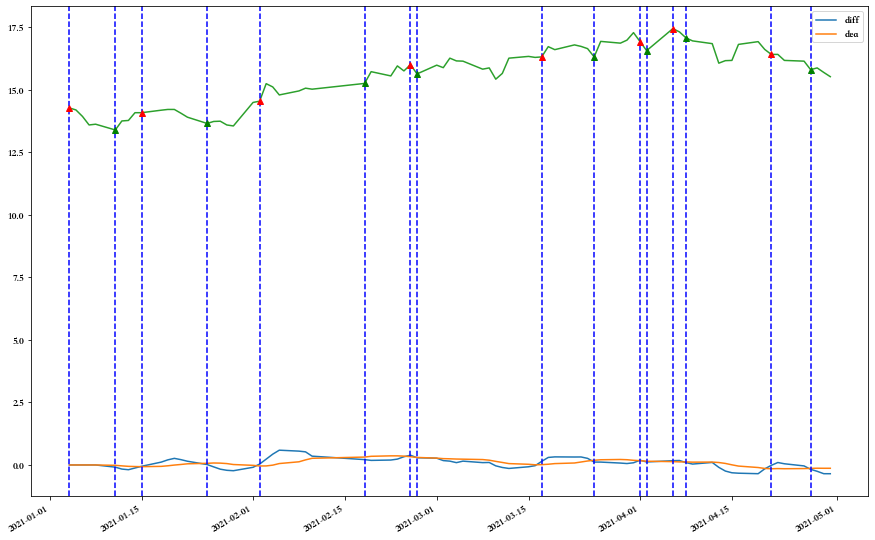

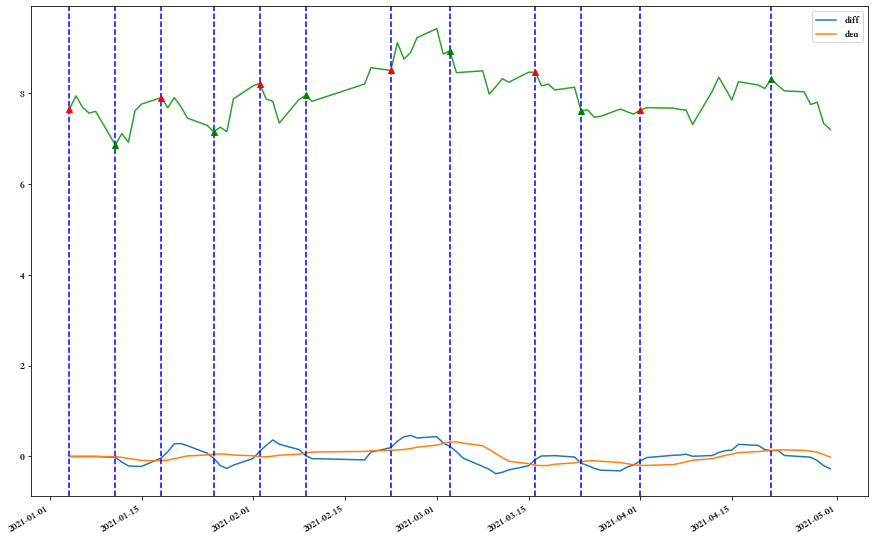

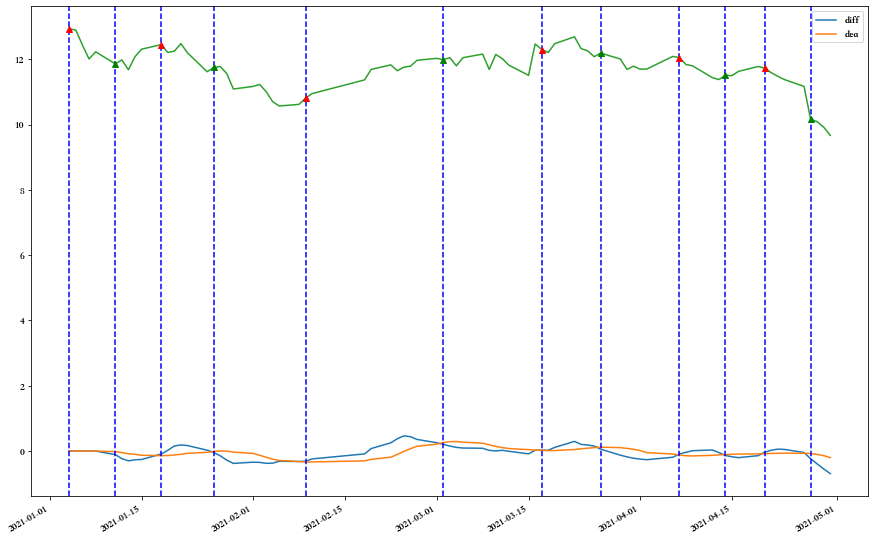

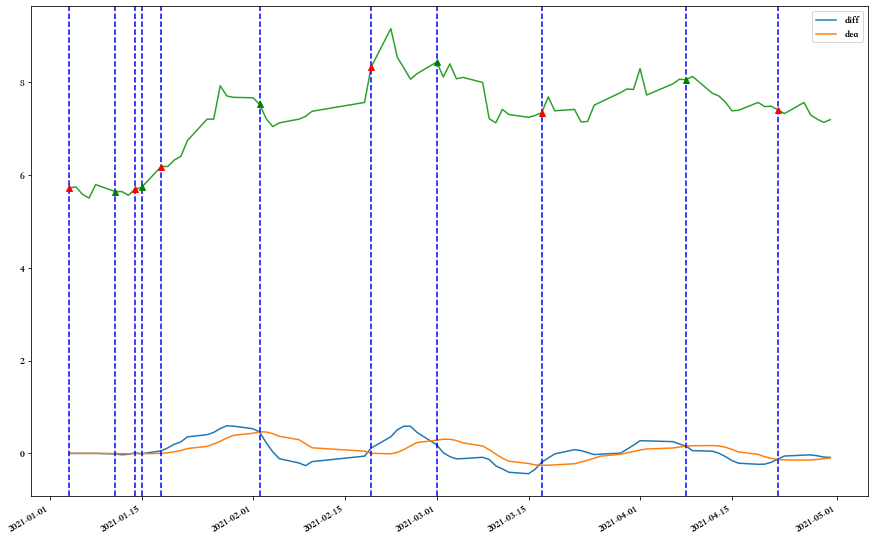

日期:2021-01-04 00:00:00,买入:002312.XSHE,数量:4363,金额:25000.0,剩余现金:75000.0
日期:2021-01-04 00:00:00,买入:300423.XSHE,数量:1980,金额:25000.0,剩余现金:50000.0
日期:2021-01-04 00:00:00,买入:603299.XSHG,数量:3531,金额:25000.0,剩余现金:25000.0
日期:2021-01-04 00:00:00,买入:603458.XSHG,数量:1751,金额:25000.0,剩余现金:0.0
卖出全部持有股票
日期:2021-01-11 00:00:00,卖出:002312.XSHE,数量:4363,金额:25043.620000000003,剩余现金:25043.620000000003
卖出全部持有股票
日期:2021-01-11 00:00:00,卖出:300423.XSHE,数量:1980,金额:24215.4,剩余现金:49259.020000000004
卖出全部持有股票
日期:2021-01-11 00:00:00,卖出:603299.XSHG,数量:3531,金额:26517.809999999998,剩余现金:75776.83
卖出全部持有股票
日期:2021-01-11 00:00:00,卖出:603458.XSHG,数量:1751,金额:23901.15,剩余现金:99677.98000000001
日期:2021-01-14 00:00:00,买入:002312.XSHE,数量:4504,金额:25000.0,剩余现金:74677.98000000001
卖出全部持有股票
日期:2021-01-15 00:00:00,卖出:002312.XSHE,数量:4504,金额:25627.760000000002,剩余现金:100305.74000000002
日期:2021-01-15 00:00:00,买入:603458.XSHG,数量:1764,金额:25000.0,剩余现金:75305.74000000002
日期:2021-01-18 00:00:00,买入:002312.XSHE,数量:4325,金额:25000.0,剩余现金:50305.74000000002
日期:2021-01-

defaultdict(<function __main__.<lambda>()>,
            {'cash': 85176.03000000003,
             '002312.XSHE': 3364,
             '300423.XSHE': 0,
             '603299.XSHG': 0,
             '603458.XSHG': 0,
             'date': '2020-04-30'})

In [17]:
################################################################
# 全局参数
start_date = '2021-01-01'
end_date = '2021-04-30'
today_data = '2020-04-30' # 检查当天持仓情况的日期


signal_df = get_signal_df(code_list,start_date,end_date,ma1,ma2,dea,info)

port = simulate_buy_sell(port,signal_df)
pickle_save(port_path,port)
port['date']=today_data
port

## 模拟今日交易

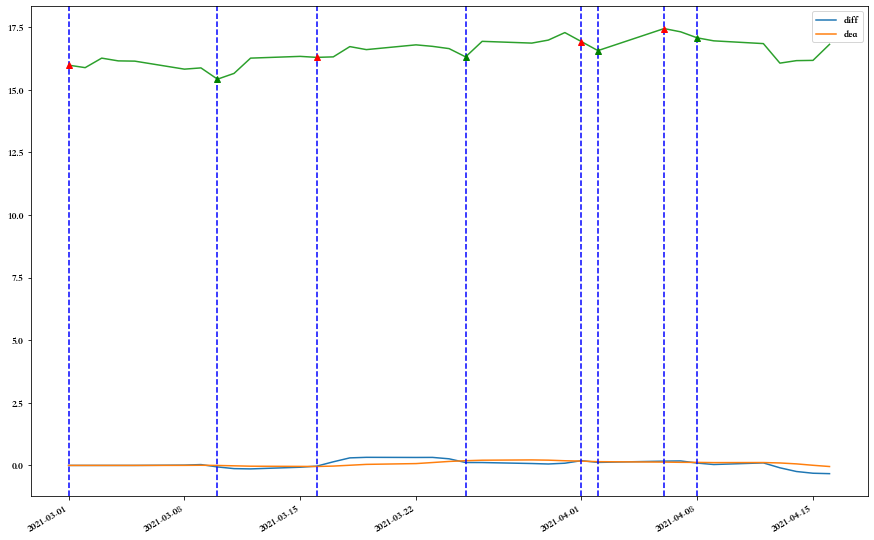

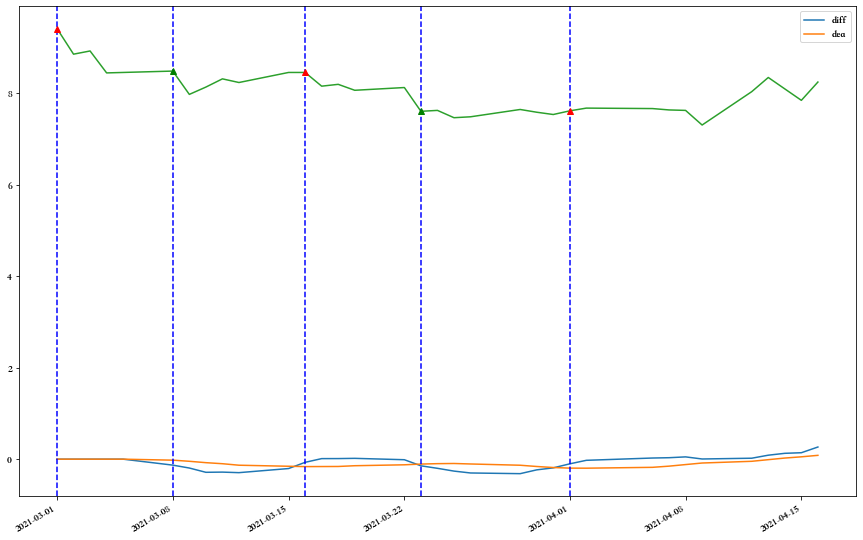

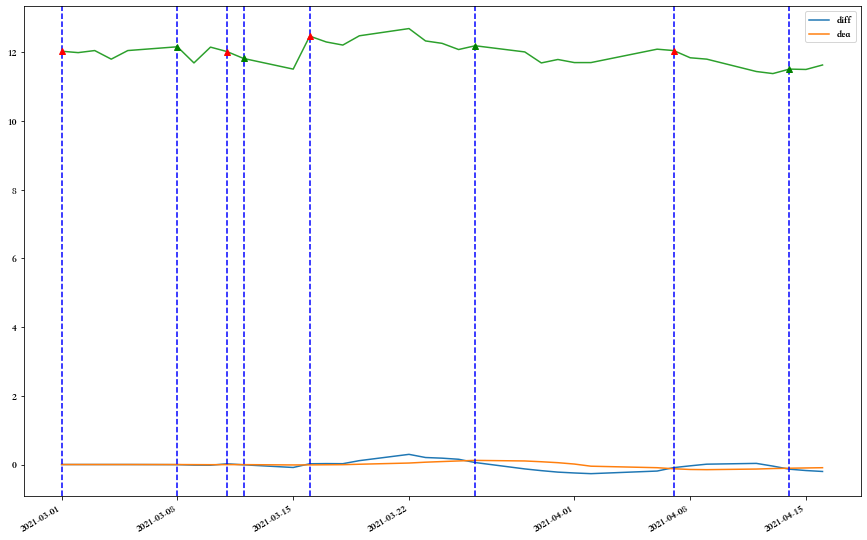

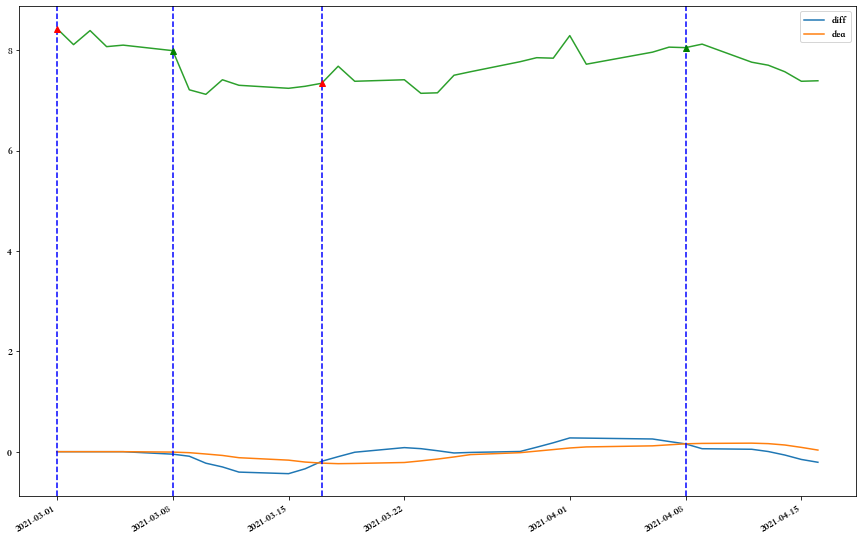

卖出全部持有股票
日期:2021-04-14 00:00:00,卖出:300423.XSHE,数量:0,金额:0.0,剩余现金:85176.03000000003

当前持仓的价值为: 109968.71000000002


defaultdict(<function __main__.<lambda>()>,
            {'cash': 85176.03000000003,
             '002312.XSHE': 3364,
             '300423.XSHE': 0,
             '603299.XSHG': 0,
             '603458.XSHG': 0,
             'date': '2021-04-16'})

In [18]:
################################################################
# 全局参数
start_date = '2021-03-01'
end_date = '2021-04-16'
today_data = '2021-04-16' # 检查当天持仓情况的日期


signal_df = get_signal_df(code_list,start_date,end_date,ma1,ma2,dea,info)

port = simulate_buy_sell_today(port,signal_df)
port['date']=today_data
pickle_save(port_path,port)
port

# 进行定期测试

In [ ]:
from apscheduler.schedulers.blocking import BlockingScheduler
from datetime import datetime
# 输出时间
def job():
    global port
    start_date = '2021-01-01'
    # 得到今天日期
    today_data = datetime.today().strftime(format='%Y-%m-%d')
    end_date = today_data = str(today_data)    
    
    signal_df = get_signal_df(code_list,start_date,end_date,ma1,ma2,dea,info)

    port = simulate_buy_sell_today(port,signal_df)
    port['date']=today_data
    pickle_save(port_path,port)
    print(port)

# BlockingScheduler
scheduler = BlockingScheduler()
scheduler.add_job(job, 'cron', day_of_week='0-6', hour=23, minute=1)
scheduler.start()

# https://www.cnblogs.com/fengff/p/11011000.html